# Radar Chart
https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

In [187]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [188]:
from matplotlib.patches import Circle, RegularPolygon, Patch
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [189]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.
    
    This function creates a RadarAxes projection and registers it.
    
    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    
    class RadarAxes(PolarAxes):
        
        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')
        
        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)
        
        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)
                
        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            # fixed original issue
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [190]:
def example_data():
    
    data = [
        ['Fact 1','Fact 2','Fact 3','Fact 4','Fact 5','Fact 6'],
        ('Scenario 1', [0.12, 0.05, 0.30, 0.22, 0.10, 0.00]),
        ('Scenario 2', [0.33, 0.72, 0.64, 0.53, 0.88, 0.12]),
        ('Scenario 3', [0.10, 0.30, 0.50, 0.70, 0.90, 0.99])
    ]
    return data

In [191]:
def convert_data_to_grid(array_1d):
    
    conversion_matrix = np.array([
        [1,1,0,0,0,1],
        [1,1,1,0,0,0],
        [0,1,1,1,0,0],
        [0,0,1,1,1,0],
        [0,0,0,1,1,1],
        [1,0,0,0,1,1]
    ])
    
    return np.matmul(np.diag(array_1d), conversion_matrix)

In [192]:
def assign_bins(val):
    
    return int(np.ceil(val*100 / 20))

In [193]:
def assign_color(array_1d):
    
    bins = [0, 1, 2, 3, 4, 5]
    colors = ['white', 'blue', 'green', 'yellow', 'red', 'purple']
    color_dict = dict(zip(bins, colors))
    
    return np.array([color_dict[assign_bins(x)] for x in array_1d])

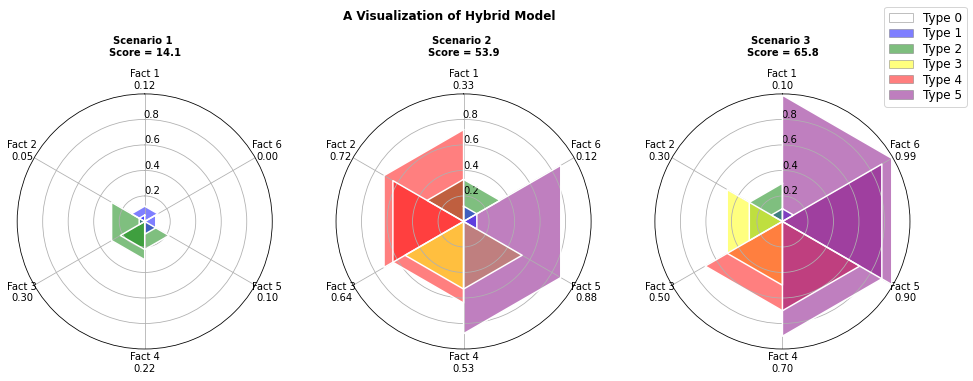

In [194]:
if __name__ == '__main__':
    
    # visualize with 6 dimensions
    N = 6
    theta = radar_factory(N, frame='circle')
    
    data = example_data()
    spoke_labels = data.pop(0)
    
    fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=3,
                             subplot_kw=dict(projection='radar'))
    
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
    
    for ax, (title, case_data) in zip(axes.flat, data):
        score_labels = [a+"\n%.2f"%b for (a,b) in zip(spoke_labels, case_data)]
        total_score = np.dot(case_data, np.array([1,1,2,2,2,2])*10)
        title = title + " \nScore = %.1f"%total_score
        
        ax.set_rgrids([.2, .4, .6, .8], angle=.5)
        ax.set_ylim(0,1)
        ax.set_title(f"{title}\n", weight='bold', size='medium', position=(.5, 1.2),
                     horizontalalignment='center', verticalalignment='center')
        grid_data = convert_data_to_grid(case_data)
        colors = assign_color(case_data)
        
        for d, color in zip(grid_data, colors):
            ax.plot(theta, d, color='w')
            ax.fill(theta, d, facecolor=color, alpha=.5)
            
        ax.set_varlabels(score_labels)
        
    fig.text(.5, .8, 'A Visualization of Hybrid Model', 
             horizontalalignment='center', color='black', weight='bold', size='large')
    
    legend_elements = [
        Patch(facecolor='white',  edgecolor='gray', alpha=.5, label='Type 0'),
        Patch(facecolor='blue',   edgecolor='gray', alpha=.5, label='Type 1'),
        Patch(facecolor='green',  edgecolor='gray', alpha=.5, label='Type 2'),
        Patch(facecolor='yellow', edgecolor='gray', alpha=.5, label='Type 3'),
        Patch(facecolor='red',    edgecolor='gray', alpha=.5, label='Type 4'),
        Patch(facecolor='purple', edgecolor='gray', alpha=.5, label='Type 5'),
    ]
    
    legend = ax.legend(handles=legend_elements, loc=(.9, .95), labelspacing=.2, fontsize='large')
    plt.show()